In [41]:
import yaml
import cv2
import torch
import matplotlib.pyplot as plt
from Datasets.create_dataset import get_dataset, SkinDataset2, StrongWeakAugment2
from Utils.pieces import DotDict
import numpy as np
from Models.Transformer.SwinUnet import SwinUnet
import os
import pandas as pd

config = yaml.load(open("Configs/multi_train_local.yml"), Loader=yaml.FullLoader)
config["fold"] = 1
config["data"]["supervised_ratio"] = 0.01
# update dataset
ls_update_keys = [
    "name",
    "save_folder",
    "test_folder",
    "train_folder",
    "val_folder",
]
for key in ls_update_keys:
    config["data"][key] = config["data"][key].replace("isic2018", "lisc")

config = DotDict(config)
dataset = get_dataset(
    config,
    img_size=config["data"]["img_size"],
    supervised_ratio=config["data"]["supervised_ratio"],
    train_aug=config["data"]["train_aug"],
    k=config["fold"],
    lb_dataset=SkinDataset2,
    ulb_dataset=StrongWeakAugment2,
)

test_loader = torch.utils.data.DataLoader(
    dataset["val_dataset"],
    batch_size=1,
    shuffle=False,
    num_workers=config.test.num_workers,
    pin_memory=True,
    drop_last=False,
)

Train Data: A172_Phase_A7_1_00d00h00m_3.npy - 1296
Labeled Data: A172_Phase_D7_2_02d04h00m_1.npy - 12
Unlabeled Data: A172_Phase_A7_1_00d00h00m_3.npy - 1284
Val Data: A172_Phase_A7_1_00d12h00m_1.npy - 324


# LiveCells (8 categories)

In [60]:
import torch.nn as nn
from Utils.losses import dice_loss


# Assuming your model is a custom ConvNet
def load_model(model_path):
    model = model = SwinUnet(img_size=224)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model


criterion = [nn.BCELoss(), dice_loss]
model_path = os.path.join(os.getcwd(), "outputs", "livecells", "best.pth")
model = load_model(model_path)
model = model.cuda()

best_inferences = []
for idx, batch in enumerate(test_loader):
    org_img = batch["org_image"].cuda().float()
    img = batch["image"].cuda().float()
    label = batch["label"].cuda().float()

    with torch.no_grad():
        pred_output = model(img)
        pred_output = torch.sigmoid(pred_output)

        # calculate loss
        assert pred_output.shape == label.shape
        losses = []
        for function in criterion:
            losses.append(function(pred_output, label))

        # for visualization
        cell_type = batch["name"][0].split("_")[0]
        org_img = org_img[0].cpu().numpy().transpose(1, 2, 0).astype(int)
        label = label[0].cpu().numpy().transpose(1, 2, 0).astype(int)
        pred_output = pred_output[0].cpu().numpy().transpose(1, 2, 0)
        # pred_output = np.where(pred_output > 0.2, 1, 0)

        best_inferences.append((cell_type, org_img, label, pred_output, losses[0]))

SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


C:\Users\predator\AppData\Local\Temp\ipykernel_3272\2647335615.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [61]:
len(best_inferences)

324

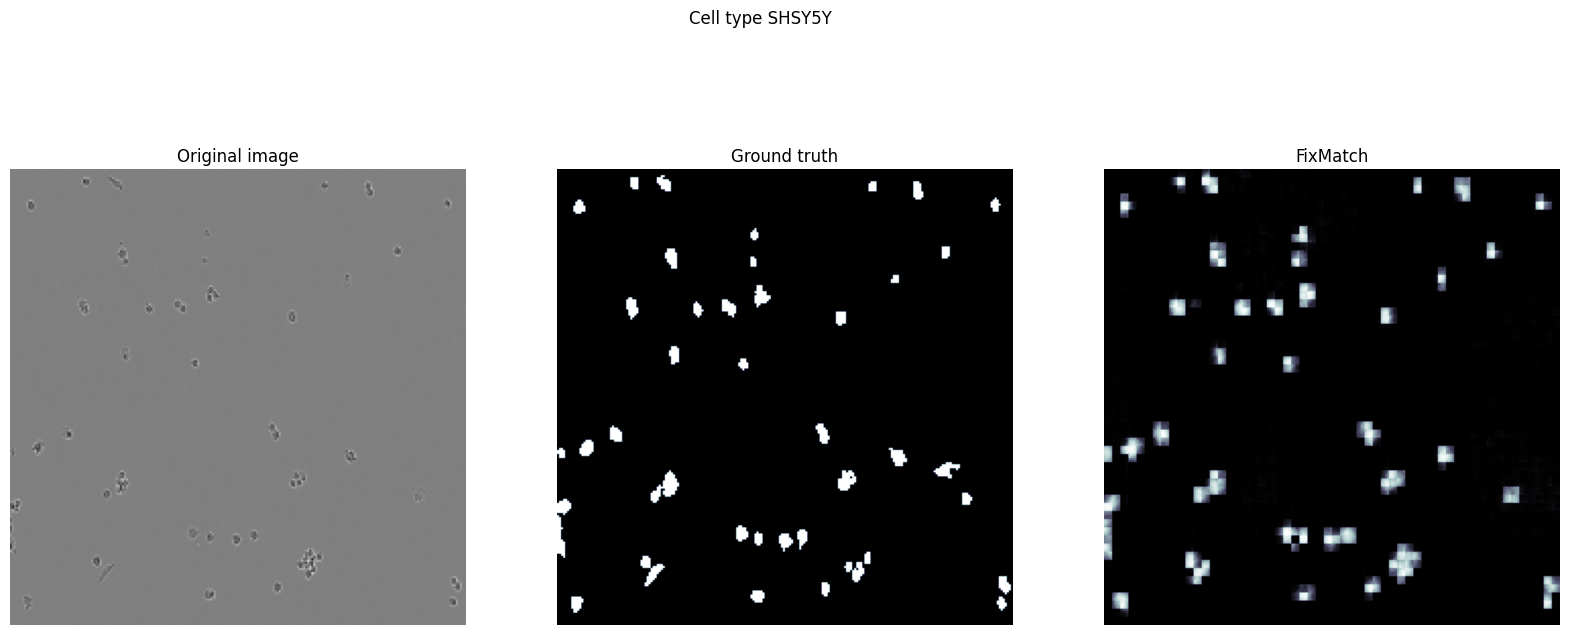

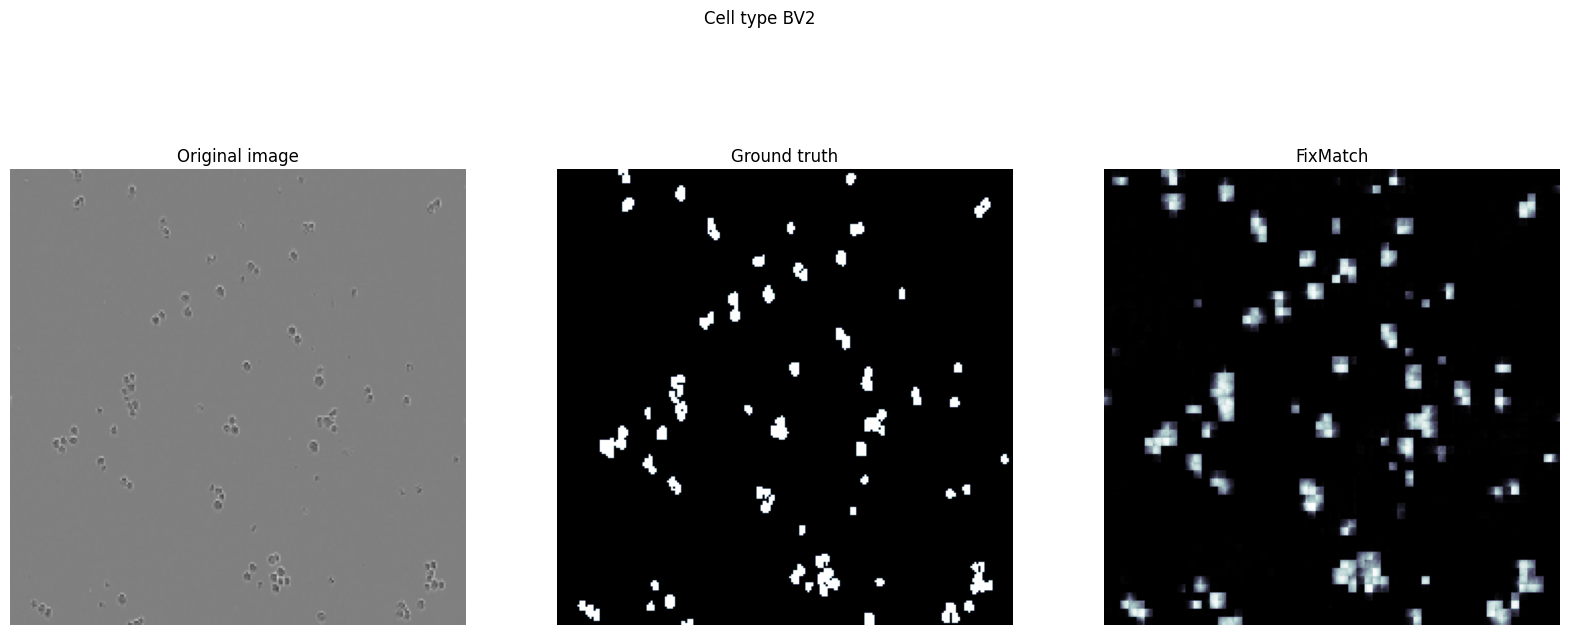

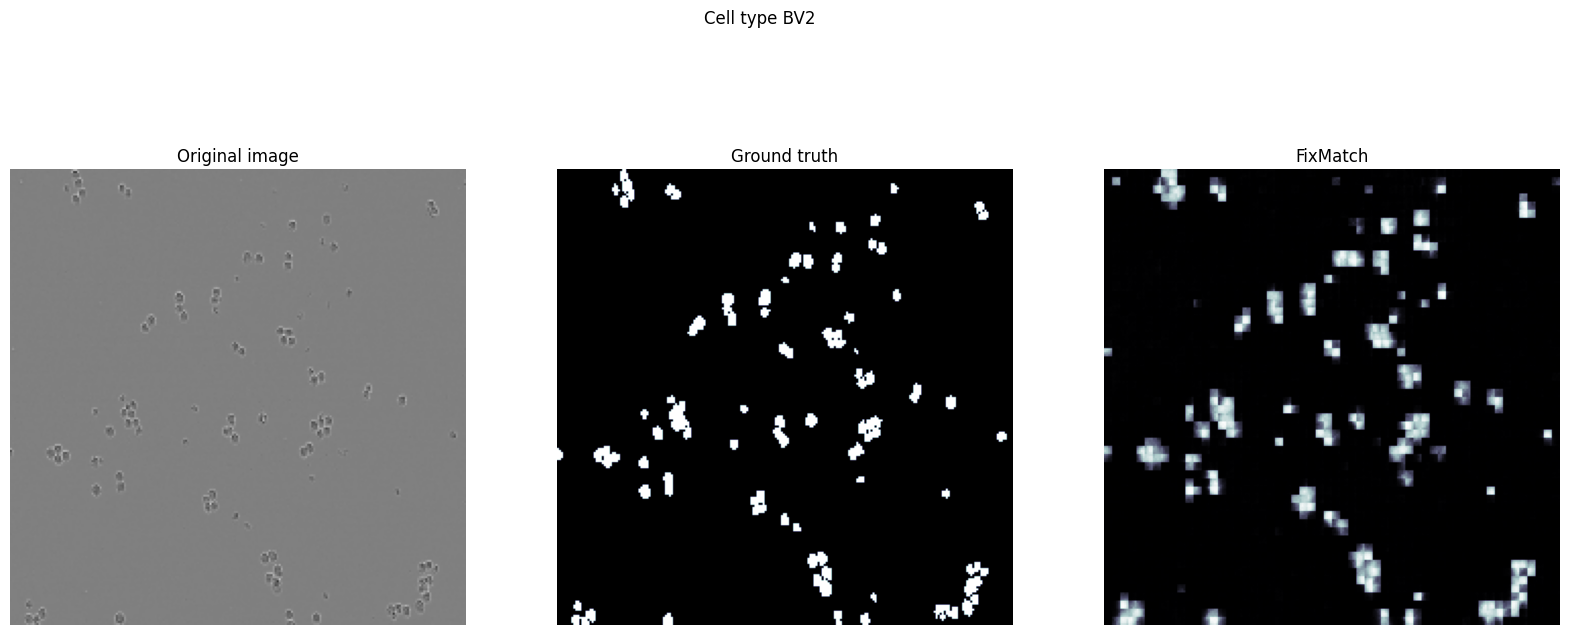

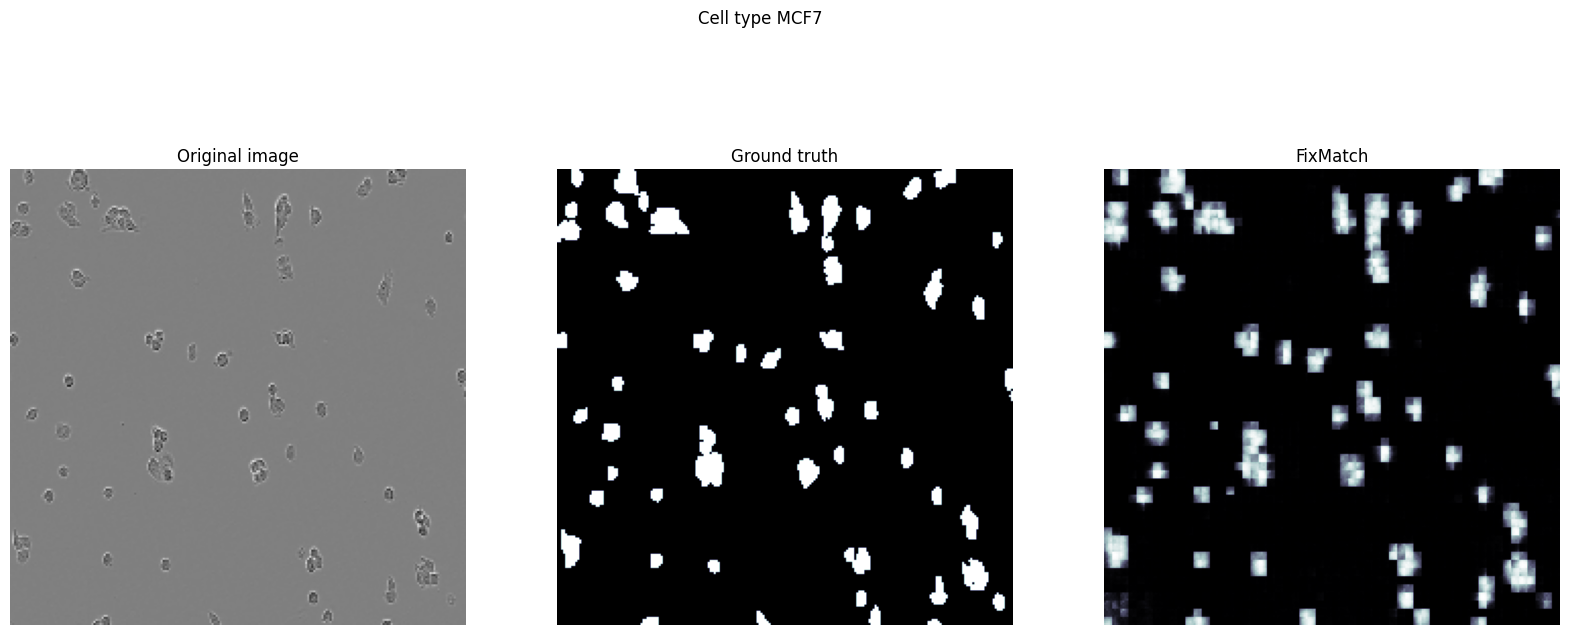

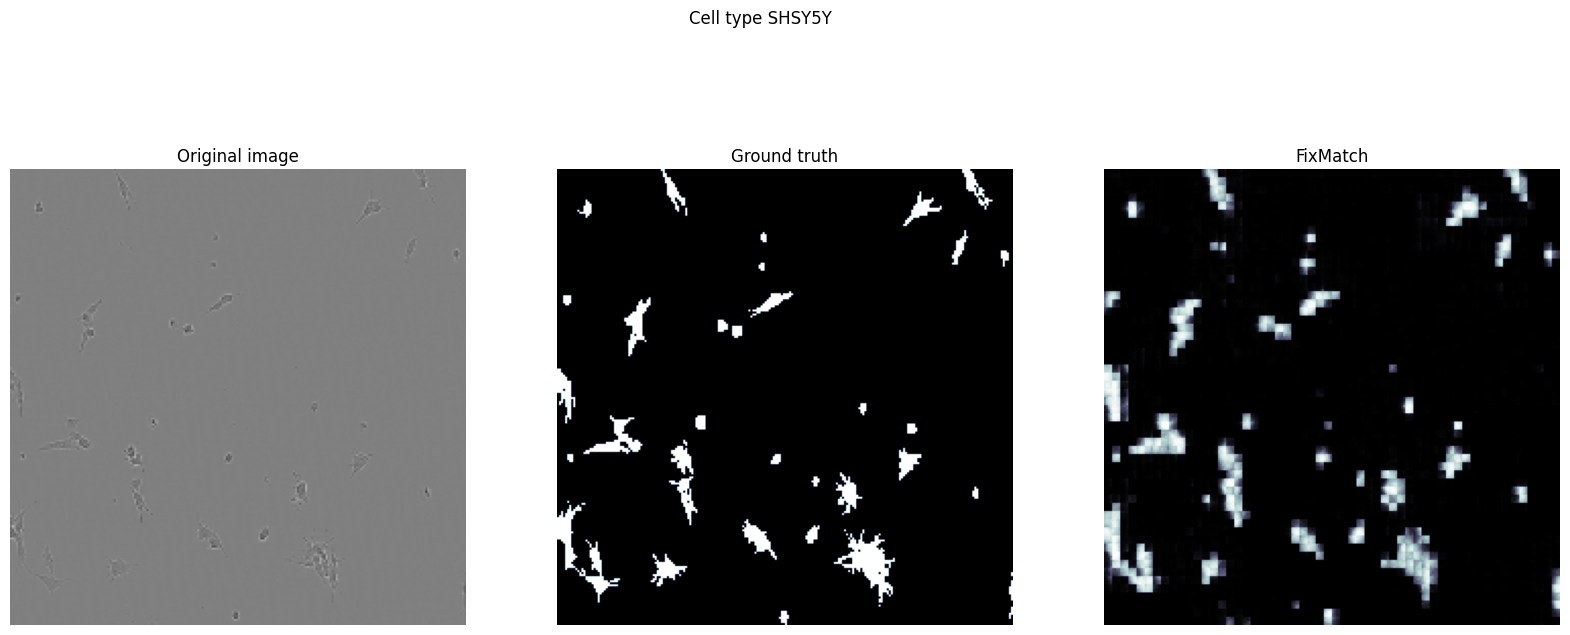

In [64]:
# Sort by loss in descending order
num_images = 10
best_inferences.sort(key=lambda x: x[-1], reverse=False)
type_check_num = {}
for i, (cell_type, org_img, label, pred_output, loss) in enumerate(
    best_inferences[:num_images]
):
    if cell_type not in type_check_num:
        type_check_num[cell_type] = 0
    if type_check_num[cell_type] > 1:
        continue

    type_check_num[cell_type] += 1

    # plot original
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

    ax1.imshow(org_img, cmap="bone")
    ax1.set_title("Original image")
    ax1.axis("off")

    # ax2.imshow(org_img, cmap='bone')
    ax2.imshow(label, cmap="bone")
    ax2.set_title("Ground truth")
    ax2.axis("off")

    # ax3.imshow(org_img, cmap='bone')
    ax3.imshow(pred_output, cmap="bone")
    ax3.set_title("FixMatch")
    ax3.axis("off")

    class_label = "Cell type " + cell_type
    fig.suptitle(class_label)
    plt.show()

In [2]:
# plot origin + mask GT

In [ ]:
# plot origin + predicted mask (fixmatch, cct, cps, ccvc, unimatch)